In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import time
import copy
import glob
import cv2
import shutil

import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt

In [3]:
data_path = '/content/drive/MyDrive/Colab Notebooks/image_data/train'
transform = transforms.Compose(
                [
                    transforms.Resize([256, 256]),
                    transforms.RandomResizedCrop(224),
                    transforms.RandomHorizontalFlip(),
                    transforms.ToTensor(),
                ])
train_dataset = torchvision.datasets.ImageFolder(
    data_path,
    transform=transform
)
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=32,
    num_workers=8,
    shuffle=True
)

print(len(train_dataset))

190


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


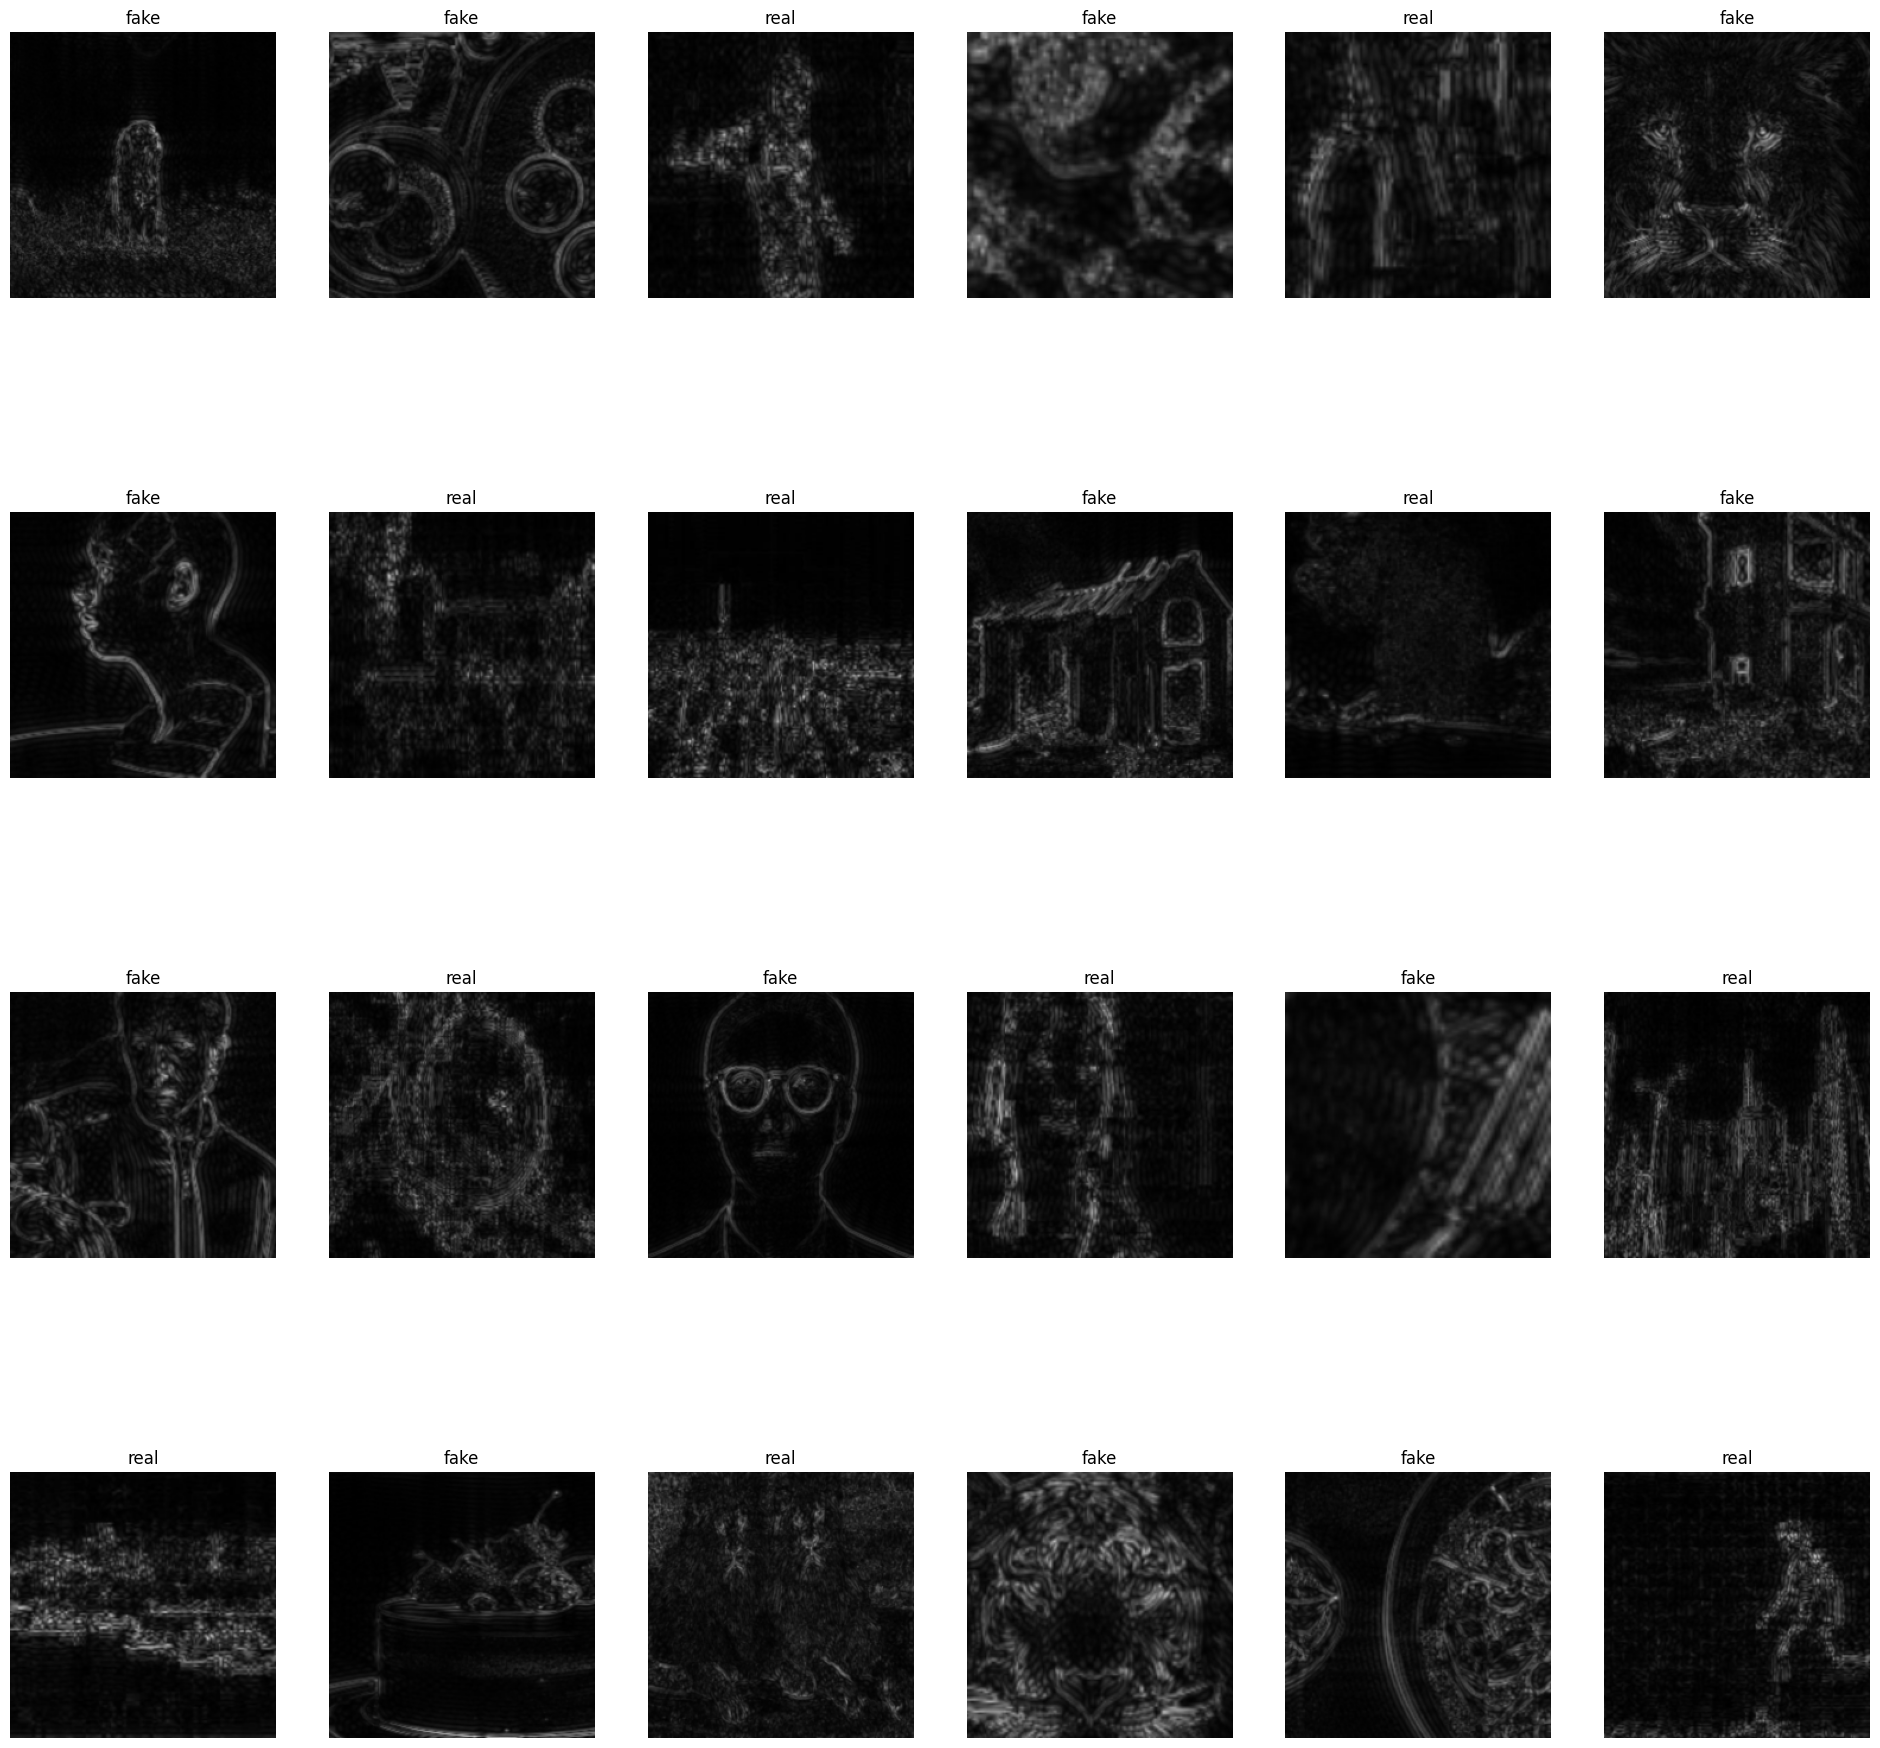

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have already defined your train_loader
# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

samples, labels = next(iter(train_loader))
classes = {0: 'fake', 1: 'real'}
fig = plt.figure(figsize=(24, 48))

for i in range(24):
    a = fig.add_subplot(4, 6, i + 1)
    a.set_title(classes[labels[i].item()])
    a.axis('off')
    a.imshow(np.transpose(samples[i].numpy(), (1, 2, 0)))

plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)
plt.show()


In [5]:
resnet18 = models.resnet18(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 129MB/s]


In [6]:
def set_parameter_requires_grad(model, feature_extracting=True):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

set_parameter_requires_grad(resnet18)

In [7]:
resnet18.fc = nn.Linear(512, 2)

In [8]:
for name, param in resnet18.named_parameters():
    if param.requires_grad:
        print(name, param.data)

fc.weight tensor([[-0.0375,  0.0076, -0.0128,  ..., -0.0237,  0.0351, -0.0395],
        [-0.0182, -0.0164, -0.0191,  ..., -0.0069,  0.0391, -0.0372]])
fc.bias tensor([ 0.0161, -0.0103])


In [9]:
model = models.resnet18(pretrained = True)

for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Linear(512, 2)
for param in model.fc.parameters():
    param.requires_grad = True

optimizer = torch.optim.Adam(model.fc.parameters())
cost = torch.nn.CrossEntropyLoss()
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [40]:
def train_model(model, dataloaders, criterion, optimizer, device, num_epochs=13, is_train=True):
    since = time.time()
    acc_history = []
    loss_history = []
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders:
            inputs = inputs.to(device)
            labels = labels.to(device)

            model.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(dataloaders.dataset)
        epoch_acc = running_corrects.double() / len(dataloaders.dataset)

        print('Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

        if epoch_acc > best_acc:
            best_acc = epoch_acc

        acc_history.append(epoch_acc.item())
        loss_history.append(epoch_loss)
        torch.save(model.state_dict(), os.path.join('/content/drive/MyDrive/Colab Notebooks/image_data', '{0:0=2d}.pth'.format(epoch)))
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Acc: {:4f}'.format(best_acc))
    return acc_history, loss_history

In [32]:
params_to_update = []
for name,param in resnet18.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

optimizer = optim.Adam(params_to_update)

	 fc.weight
	 fc.bias


In [41]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()
train_acc_hist, train_loss_hist = train_model(resnet18, train_loader, criterion, optimizer, device)

Epoch 0/12
----------
Loss: 0.2684 Acc: 0.8789

Epoch 1/12
----------
Loss: 0.2254 Acc: 0.9211

Epoch 2/12
----------
Loss: 0.2404 Acc: 0.8895

Epoch 3/12
----------
Loss: 0.2462 Acc: 0.8895

Epoch 4/12
----------
Loss: 0.2211 Acc: 0.9211

Epoch 5/12
----------
Loss: 0.2231 Acc: 0.9053

Epoch 6/12
----------
Loss: 0.2147 Acc: 0.9158

Epoch 7/12
----------
Loss: 0.2061 Acc: 0.9105

Epoch 8/12
----------
Loss: 0.1893 Acc: 0.9421

Epoch 9/12
----------
Loss: 0.1936 Acc: 0.9211

Epoch 10/12
----------
Loss: 0.2127 Acc: 0.9000

Epoch 11/12
----------
Loss: 0.2541 Acc: 0.8737

Epoch 12/12
----------
Loss: 0.1888 Acc: 0.9316

Training complete in 5m 25s
Best Acc: 0.942105


In [42]:
test_path = '/content/drive/MyDrive/Colab Notebooks/image_data/test'

transform = transforms.Compose(
                [
                    transforms.Resize(224),
                    transforms.CenterCrop(224),
                    transforms.ToTensor(),
                ])
test_dataset = torchvision.datasets.ImageFolder(
    root=test_path,
    transform=transform
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=32,
    num_workers=1,
    shuffle=True
)

print(len(test_dataset))

120


In [45]:
def eval_model(model, dataloaders, device):
    since = time.time()
    acc_history = []
    best_acc = 0.0

    saved_models = glob.glob('/content/drive/MyDrive/Colab Notebooks/image_data' + '/*.pth')
    saved_models.sort()
    print('saved_model', saved_models)

    for model_path in saved_models:
        print('Loading model', model_path)

        model.load_state_dict(torch.load(model_path))
        model.eval()
        model.to(device)
        running_corrects = 0

        for inputs, labels in dataloaders:
            inputs = inputs.to(device)
            labels = labels.to(device)

            with torch.no_grad():
                outputs = model(inputs)

            _, preds = torch.max(outputs.data, 1)
            running_corrects += torch.sum(preds == labels.data)

        epoch_acc = running_corrects.double() / len(dataloaders.dataset)
        print('Acc: {:.4f}'.format(epoch_acc))

        if epoch_acc > best_acc:
            best_acc = epoch_acc

        acc_history.append(epoch_acc.item())
        print()

    time_elapsed = time.time() - since
    print('Validation complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Acc: {:4f}'.format(best_acc))

    return acc_history


In [46]:
val_acc_hist = eval_model(resnet18, test_loader, device)

saved_model ['/content/drive/MyDrive/Colab Notebooks/image_data/00.pth', '/content/drive/MyDrive/Colab Notebooks/image_data/01.pth', '/content/drive/MyDrive/Colab Notebooks/image_data/02.pth', '/content/drive/MyDrive/Colab Notebooks/image_data/03.pth', '/content/drive/MyDrive/Colab Notebooks/image_data/04.pth', '/content/drive/MyDrive/Colab Notebooks/image_data/05.pth', '/content/drive/MyDrive/Colab Notebooks/image_data/06.pth', '/content/drive/MyDrive/Colab Notebooks/image_data/07.pth', '/content/drive/MyDrive/Colab Notebooks/image_data/08.pth', '/content/drive/MyDrive/Colab Notebooks/image_data/09.pth', '/content/drive/MyDrive/Colab Notebooks/image_data/10.pth', '/content/drive/MyDrive/Colab Notebooks/image_data/11.pth', '/content/drive/MyDrive/Colab Notebooks/image_data/12.pth']
Loading model /content/drive/MyDrive/Colab Notebooks/image_data/00.pth
Acc: 0.8667

Loading model /content/drive/MyDrive/Colab Notebooks/image_data/01.pth
Acc: 0.8667

Loading model /content/drive/MyDrive/Co

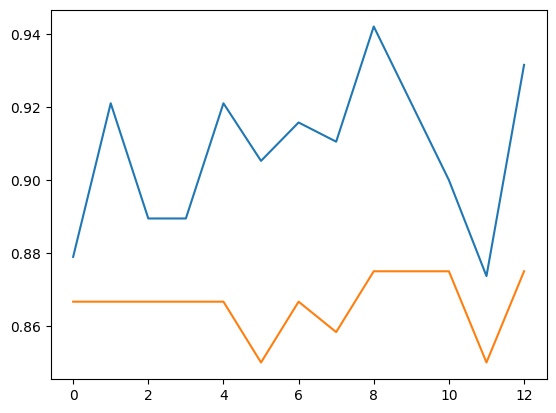

In [47]:
plt.plot(train_acc_hist)
plt.plot(val_acc_hist)
plt.show()

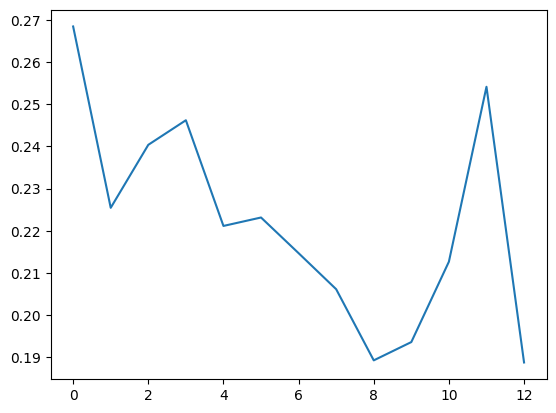

In [48]:
plt.plot(train_loss_hist)
plt.show()

In [49]:
def im_convert(tensor):
    image=tensor.clone().detach().numpy()
    image=image.transpose(1,2,0)
    image=image*(np.array((0.5,0.5,0.5))+np.array((0.5,0.5,0.5)))
    image=image.clip(0,1)
    return image

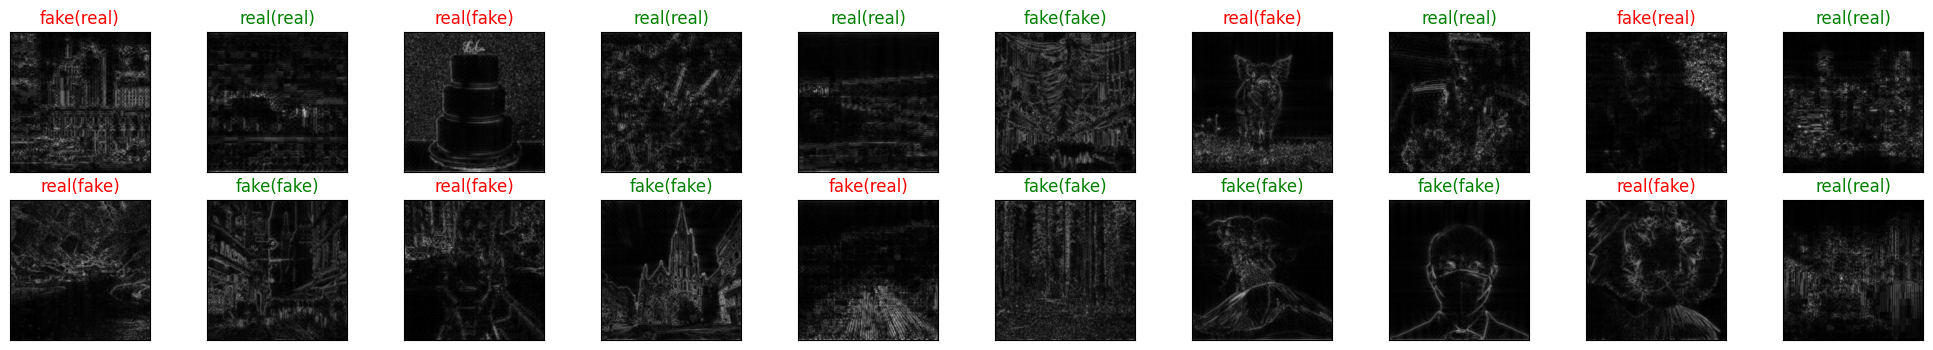

<Figure size 640x480 with 0 Axes>

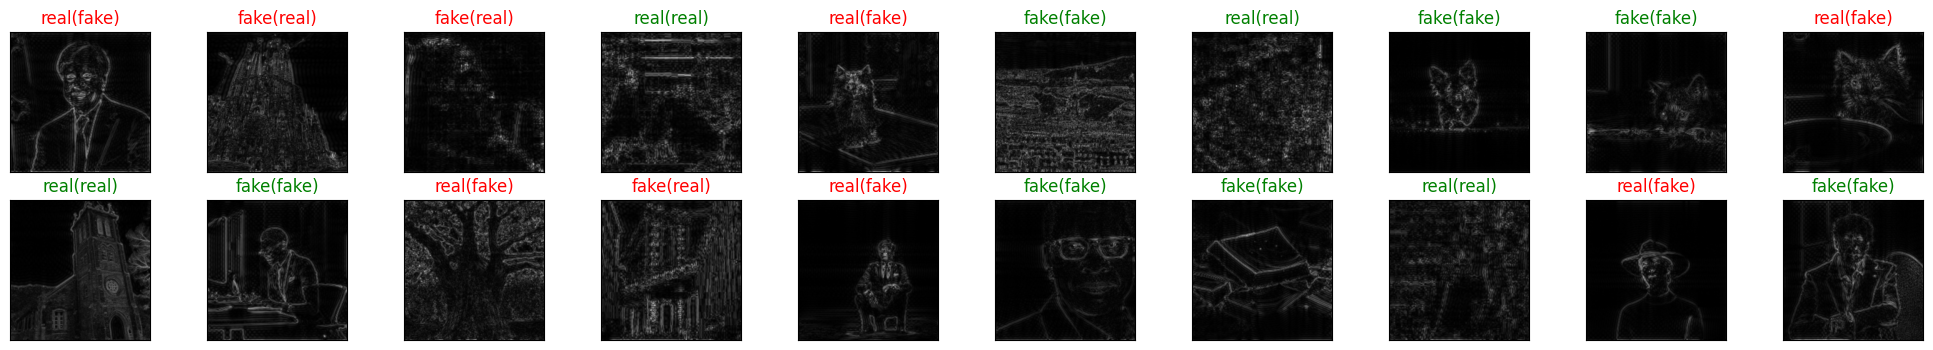

<Figure size 640x480 with 0 Axes>

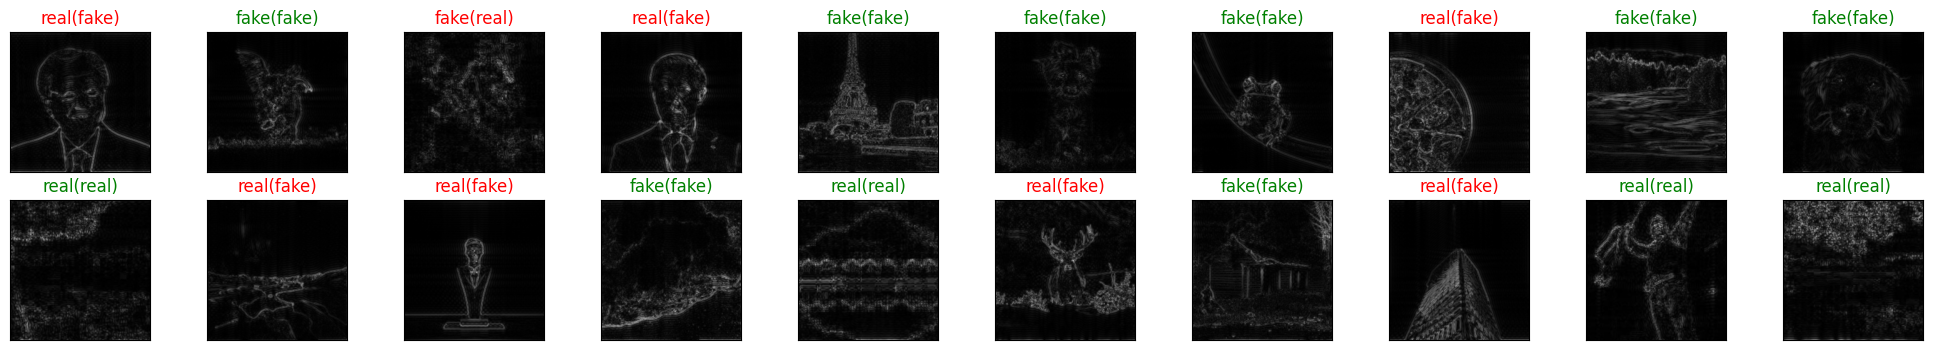

<Figure size 640x480 with 0 Axes>

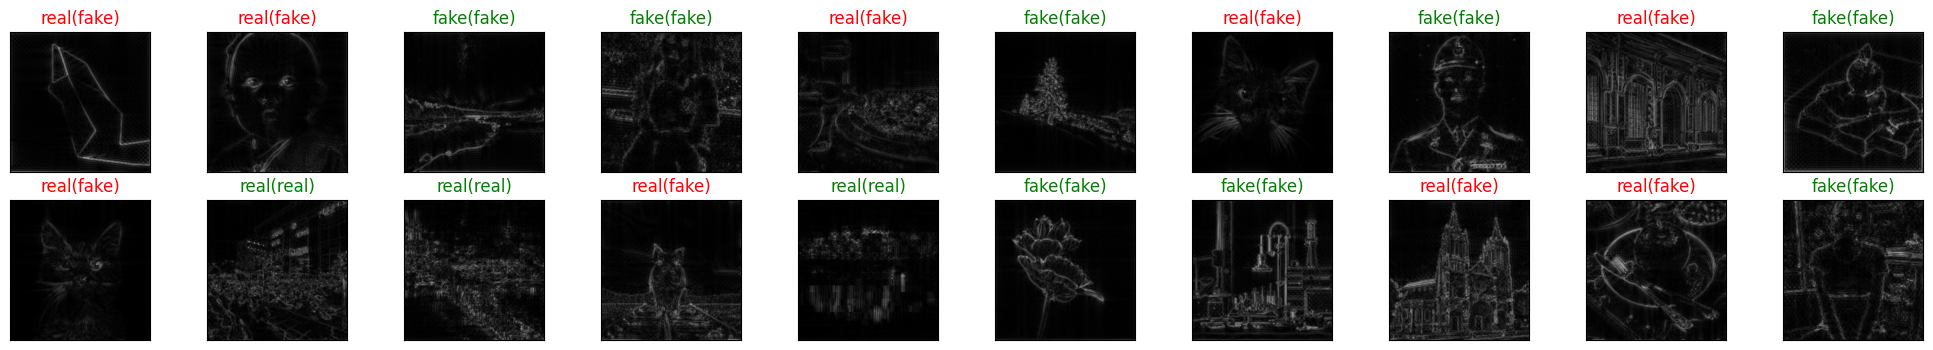

<Figure size 640x480 with 0 Axes>

In [50]:
classes = {0: 'fake', 1: 'real'}

# Assuming test_loader is your DataLoader for the test set
for images, labels in test_loader:
    output = model(images)
    _, preds = torch.max(output, 1)

    fig = plt.figure(figsize=(25, 4))
    for idx in np.arange(min(20, len(images))):  # To avoid index out of range if len(images) < 20
        ax = fig.add_subplot(2, 10, idx + 1, xticks=[], yticks=[])
        plt.imshow(im_convert(images[idx]))
        ax.set_title("{}({})".format(str(classes[preds[idx].item()]), str(classes[labels[idx].item()])),
                     color=("green" if preds[idx] == labels[idx] else "red"))
    plt.show()
    plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)
